In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 19 12:11:31 2025

@author: Mizbah, Israt, Tanvir, Kolin, Carlie, Ishmam
"""
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from pathlib import Path
import pandas as pdcond
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
data_folder = Path("D:\\LSU\\Sp_2025\\BE7910\\Data_Team3")
output_folder = Path("D:\\LSU\\Sp_2025\\BE7910\\project-1\\Outputs")
output_folder.mkdir(parents=True, exist_ok=True)

buildings = gpd.read_file(data_folder /"nsi_MultiPoint").explode(index_parts=False).reset_index(drop=True)

# -----------------------------
# Function to Extract Raster Values
# -----------------------------
def extract_values_from_band(points_gdf, raster_path, band_number, new_col_name):
    """
    Extract values from a specific raster band at point locations.
    """
    with rasterio.open(raster_path) as src:
        if points_gdf.crs != src.crs:
            points_gdf = points_gdf.to_crs(src.crs)
        
        coords = [(geom.x, geom.y) for geom in points_gdf.geometry]
        values = [val[0] if val[0] != src.nodatavals[band_number - 1] else np.nan
                  for val in src.sample(coords, indexes=band_number)]
        
        points_gdf[new_col_name] = values

    return points_gdf

# -----------------------------
# Extract Elevation Values
# -----------------------------
elevation_path = data_folder / "elevation_SingleBandRaster/SA_DEM.tif"
buildings = extract_values_from_band(buildings, elevation_path, band_number=1, new_col_name="elevation")

# -----------------------------
# Extract Flood Depths for Multiple Bands
# -----------------------------
flood_path = data_folder / "flood_MultiBandRaster/SA_FloodDepths.tif"

# Modify the flood_bands dictionary so the output column names are as desired.
# This will create columns: flood_SA_10, flood_SA_50, flood_SA_100, flood_SA_500.
flood_bands = {
    1: "10",  # 10-year return period
    2: "50",  # 50-year return period
    3: "100",  # 100-year return period
    4: "500"   # 500-year return period
}

for band_num, band_name in flood_bands.items():
    col_name = f"flood_{band_name}"
    buildings = extract_values_from_band(buildings, flood_path, band_number=band_num, new_col_name=f"flood_{band_name}")


# -----------------------------
# Flag Buildings as Affected Based on Inundation Criteria
# -----------------------------
# Define inundation thresholds for each foundation type.
def threshold_for_foundation(found_type):
    # Adjust these thresholds if needed.
    if found_type.upper() == 'S':
        return 0.5
    elif found_type.upper() == 'B':
        return 1.5
    elif found_type.upper() == 'C':
        return 2.0
    else:
        return np.nan


# Mapping of flood columns to their corresponding return period (in years)
flood_return_periods = {
    'flood_10': 10,
    'flood_50': 50,
    'flood_100': 100,
    'flood_500': 500
}

# For each flood return period, create a new column that flags if a building is affected.
# A building is affected if the flood depth exceeds the threshold for its foundation type.
for flood_col, rp in flood_return_periods.items():
    affected_col = f"aff_{rp}"
    buildings[affected_col] = buildings.apply(
        lambda row: "Yes" if row[flood_col] > threshold_for_foundation(row['found_type']) else "No",
        axis=1
    )

# -----------------------------
# Save Results to Shapefile
# -----------------------------
output_path = output_folder / "buildings_with_elevation_flood.shp"

if output_path.exists():
    output_path.unlink()

buildings.to_file(output_path, driver="ESRI Shapefile", index=False)



In [ ]:
buildings_original = 

In [18]:
print(buildings)

            fid      fd_id           cbfips st_damcat    occtype bldgtype  \
0      701864.0  524555978  220510217001018       COM       COM8        S   
1      701865.0  524555980  220510217001018       COM       COM1        S   
2      701866.0  524555982  220510217001018       COM       COM4        S   
3      701867.0  524555984  220510217001018       IND       IND2        S   
4      701868.0  524555986  220510217001018       IND       IND6        S   
...         ...        ...              ...       ...        ...      ...   
1026  1675357.0  525529541  220510217001017       RES  RES1-1SNB        W   
1027  1675364.0  525529548  220510203032012       RES  RES1-2SNB        W   
1028  1675365.0  525529549  220510203032010       RES  RES1-1SNB        W   
1029  1675366.0  525529550  220510203032004       RES  RES1-1SNB        W   
1030  1675367.0  525529551  220510217001005       RES  RES1-1SNB        W   

      num_story          sqft found_type  found_ht  ...  flood_50  flood_10

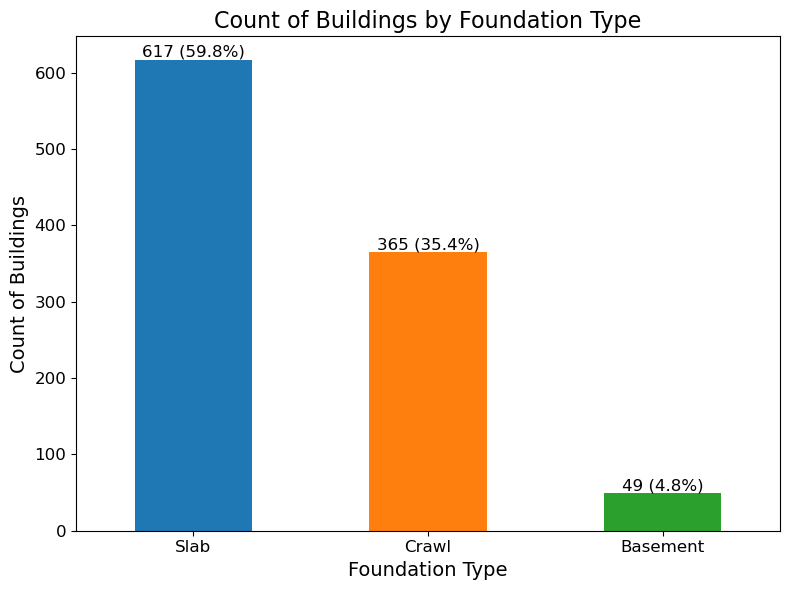

In [3]:
# Calculate the count of buildings by foundation type, sorted descending
found_type_count = buildings.groupby("found_type").size().sort_values(ascending=False)

# Mapping for full foundation type names
foundation_names = {'C': 'Crawl', 'B': 'Basement', 'S': 'Slab'}

# Calculate total count for percentage computation
total_count = found_type_count.sum()

# Create the bar plot with new colors
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # New color palette
ax = found_type_count.plot(kind='bar', color=colors, figsize=(8, 6))

# Adding titles and axis labels with larger fonts
plt.title('Count of Buildings by Foundation Type', fontsize=16)
plt.xlabel('Foundation Type', fontsize=14)
plt.ylabel('Count of Buildings', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Update x-axis tick labels to display full names
new_labels = [foundation_names.get(ftype, ftype) for ftype in found_type_count.index]
ax.set_xticklabels(new_labels)

# Annotate each bar with its count and percentage of the total count
for bar in ax.patches:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    label_text = f'{int(height)} ({percentage:.1f}%)'
    ax.annotate(label_text, 
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=12)

# Adjust layout to prevent clipping and display the plot
plt.tight_layout()
plt.show()


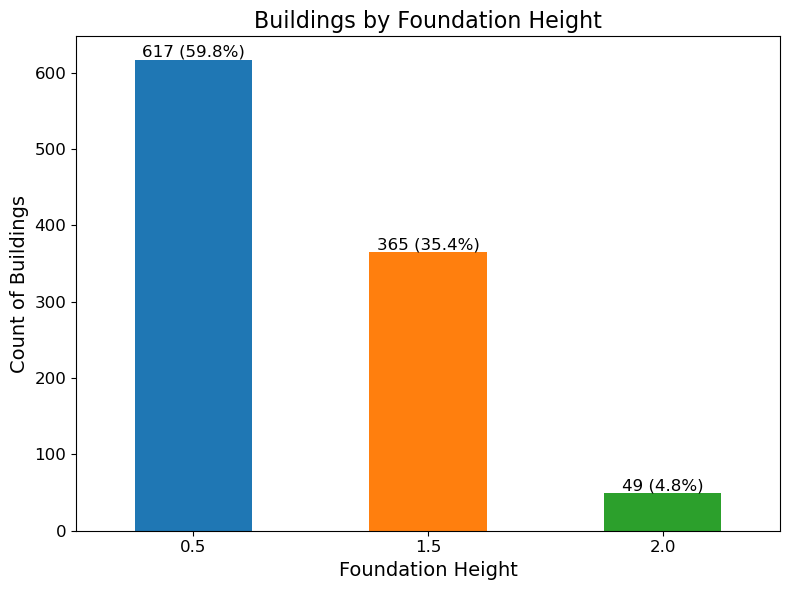

In [4]:

# Calculate the count of buildings by foundation height
fnd_height_counts = buildings["found_ht"].value_counts()
sorted_fnd_height_counts = fnd_height_counts.sort_values(ascending=False)

# Calculate total count for percentage computation
total_count = sorted_fnd_height_counts.sum()

plt.figure(figsize=(8, 6))

# Define the color palette similar to the previous plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # New color palette

# Plot the bar chart
ax = sorted_fnd_height_counts.plot(kind='bar', color=colors, figsize=(8, 6))

# Adding titles and axis labels with larger fonts
plt.title('Buildings by Foundation Height', fontsize=16)
plt.xlabel('Foundation Height', fontsize=14)
plt.ylabel('Count of Buildings', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Annotate each bar with its count and percentage of the total count
for bar in ax.patches:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    label_text = f'{int(height)} ({percentage:.1f}%)'
    ax.annotate(label_text,
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


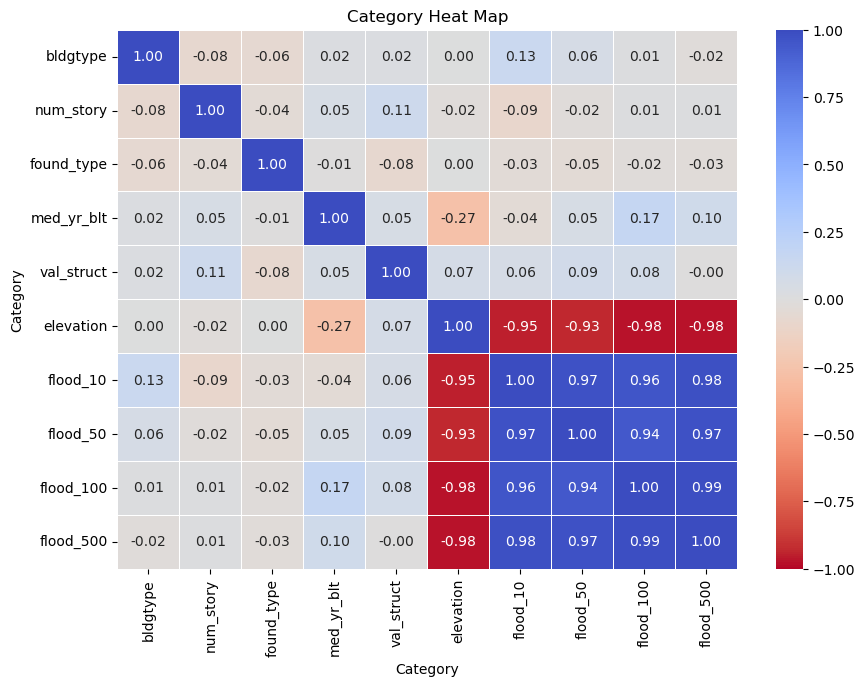

In [5]:
selected_columns = ["bldgtype", "num_story", "found_type", "med_yr_blt", "val_struct", "elevation", "flood_10", "flood_50", "flood_100", "flood_500"]
buildings_selected_columns = buildings[selected_columns]
## string to floats
buildings_selected_columns["bldgtype"] = buildings_selected_columns["bldgtype"].map({'S': 0, 'W': 1, 'M':2, 'C': 3})
buildings_selected_columns["found_type"] = buildings_selected_columns["found_type"].map({'S': 0, 'B': 1, 'C': 2})

plt.figure(figsize=(10, 7))
sns.heatmap(buildings_selected_columns.corr(),cmap="coolwarm_r", vmin=-1, vmax=1, annot=True, fmt=".2f", linewidths=0.5) #heatmap Age, Fare, Sex, Pclass, SibSp, and Survived columns and generate a correlational heatmap
plt.xlabel("Category")
plt.ylabel("Category")
plt.title("Category Heat Map")
plt.show()


In [6]:
# Count how many buildings are affected for each return period.
affected_counts = {}
for flood_col, rp in flood_return_periods.items():
    affected_col = f"aff_{rp}"
    count = (buildings[affected_col] == "Yes").sum()
    affected_counts[rp] = count

print("Number of flood-affected buildings by return period:")
for rp, count in affected_counts.items():
    print(f"{rp} year: {count} buildings")

Number of flood-affected buildings by return period:
10 year: 28 buildings
50 year: 62 buildings
100 year: 146 buildings
500 year: 213 buildings


In [9]:
df = pd.DataFrame({
    "ReturnPeriod": list(affected_counts.keys()),
    "AffectedBuildings": list(affected_counts.values())
})


In [10]:
# Fit a linear regression model.
linear_model = smf.ols(formula="AffectedBuildings ~ ReturnPeriod", data=df).fit()
print("\nLinear Model Summary:")
print(linear_model.summary())

# Fit a logarithmic model.
df['LogReturnPeriod'] = np.log(df['ReturnPeriod'])
log_model = smf.ols(formula="AffectedBuildings ~ LogReturnPeriod", data=df).fit()
print("\nLogarithmic Model Summary:")
print(log_model.summary())


Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:      AffectedBuildings   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     7.529
Date:                Mon, 24 Feb 2025   Prob (F-statistic):              0.111
Time:                        21:43:12   Log-Likelihood:                -19.677
No. Observations:                   4   AIC:                             43.35
Df Residuals:                       2   BIC:                             42.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       58.1500  

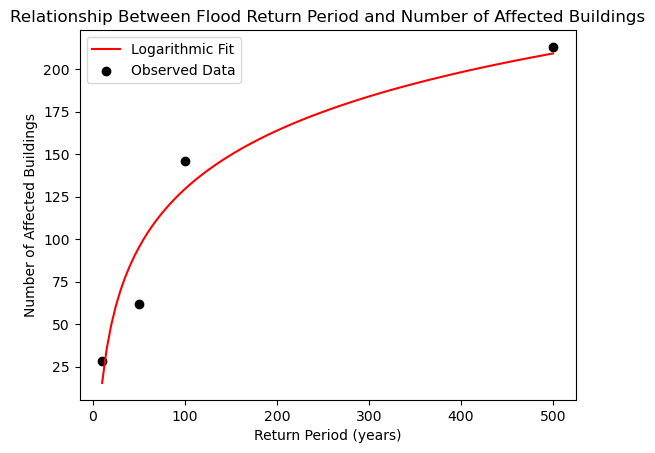

In [11]:
# Create a range of return period values for predictions.
rp_range = np.linspace(df['ReturnPeriod'].min(), df['ReturnPeriod'].max(), 100)

# Predictions from the linear model.
#linear_pred = linear_model.predict(pd.DataFrame({'ReturnPeriod': rp_range}))
#plt.plot(rp_range, linear_pred, label='Linear Fit', color='blue')

# Predictions from the logarithmic model.
log_pred = log_model.predict(pd.DataFrame({'LogReturnPeriod': np.log(rp_range)}))
plt.plot(rp_range, log_pred, label='Logarithmic Fit', color='red')
plt.scatter(df['ReturnPeriod'], df['AffectedBuildings'], label='Observed Data', color='black')

plt.xlabel('Return Period (years)')
plt.ylabel('Number of Affected Buildings')
plt.title('Relationship Between Flood Return Period and Number of Affected Buildings')
plt.legend()
plt.show()

In [12]:
# Elevation-based vulnerability (Updated Thresholds)
def classify_elevation_risk(row):
    if row["elevation"] < -5:
        return "High Risk"
    elif -5 <= row["elevation"] <= -4:
        return "Medium Risk"
    else:
        return "Low Risk"

# Structure value-based vulnerability
def classify_value_risk(row):
    if row["val_cont"] < 100000:
        return "High Risk"
    elif 100000 <= row["val_cont"] <= 500000:
        return "Medium Risk"
    else:
        return "Low Risk"

# Foundation type-based vulnerability
def classify_foundation_risk(row):
    if row["found_type"] == "S":  # Slab-on-grade
        return "High Risk"
    elif row["found_type"] == "C":  # Crawlspace
        return "Medium Risk"
    elif row["found_type"] == "P":  # Pile/Raised
        return "Low Risk"
    else:
        return "Unknown"

In [13]:
# Apply classifications
buildings["elevation_risk"] = buildings.apply(classify_elevation_risk, axis=1)
buildings["value_risk"] = buildings.apply(classify_value_risk, axis=1)
buildings["foundation_risk"] = buildings.apply(classify_foundation_risk, axis=1)

# Count occurrences of each risk level
elevation_counts = buildings["elevation_risk"].value_counts()
value_counts = buildings["value_risk"].value_counts()
foundation_counts = buildings["foundation_risk"].value_counts()

# Define color mapping
color_map = {"High Risk": "red", "Medium Risk": "orange", "Low Risk": "green", "Unknown": "blue"}



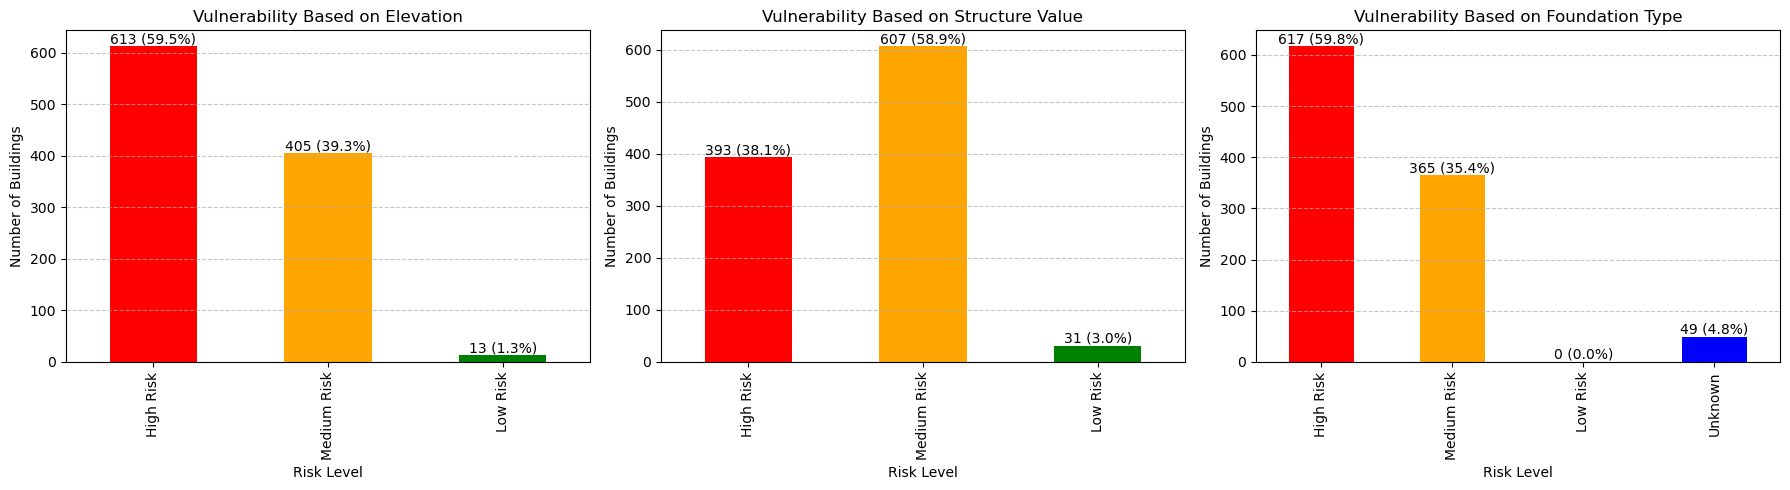

In [14]:
# Plot bar charts for each risk factor
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elevation risk chart
elevation_counts = elevation_counts.reindex(["High Risk", "Medium Risk", "Low Risk"]).fillna(0)
elevation_counts.plot(kind="bar", ax=axes[0], color=[color_map[risk] for risk in elevation_counts.index])
axes[0].set_title("Vulnerability Based on Elevation")
axes[0].set_xlabel("Risk Level")
axes[0].set_ylabel("Number of Buildings")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Annotate bars for elevation risk chart
total_elev = elevation_counts.sum()
for bar in axes[0].patches:
    height = bar.get_height()
    percentage = (height / total_elev) * 100 if total_elev > 0 else 0
    label_text = f'{int(height)} ({percentage:.1f}%)'
    axes[0].annotate(label_text,
                     (bar.get_x() + bar.get_width()/2, height),
                     ha='center', va='bottom', fontsize=10)

# Structure value risk chart 
value_counts = value_counts.reindex(["High Risk", "Medium Risk", "Low Risk"]).fillna(0)
value_counts.plot(kind="bar", ax=axes[1], color=[color_map[risk] for risk in value_counts.index])
axes[1].set_title("Vulnerability Based on Structure Value")
axes[1].set_xlabel("Risk Level")
axes[1].set_ylabel("Number of Buildings")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Annotate bars for structure value risk chart
total_value = value_counts.sum()
for bar in axes[1].patches:
    height = bar.get_height()
    percentage = (height / total_value) * 100 if total_value > 0 else 0
    label_text = f'{int(height)} ({percentage:.1f}%)'
    axes[1].annotate(label_text,
                     (bar.get_x() + bar.get_width()/2, height),
                     ha='center', va='bottom', fontsize=10)

# Foundation type risk chart
foundation_counts = foundation_counts.reindex(["High Risk", "Medium Risk", "Low Risk", "Unknown"]).fillna(0)
foundation_counts.plot(kind="bar", ax=axes[2], color=[color_map[risk] for risk in foundation_counts.index])
axes[2].set_title("Vulnerability Based on Foundation Type")
axes[2].set_xlabel("Risk Level")
axes[2].set_ylabel("Number of Buildings")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

# Annotate bars for foundation type risk chart
total_found = foundation_counts.sum()
for bar in axes[2].patches:
    height = bar.get_height()
    percentage = (height / total_found) * 100 if total_found > 0 else 0
    label_text = f'{int(height)} ({percentage:.1f}%)'
    axes[2].annotate(label_text,
                     (bar.get_x() + bar.get_width()/2, height),
                     ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


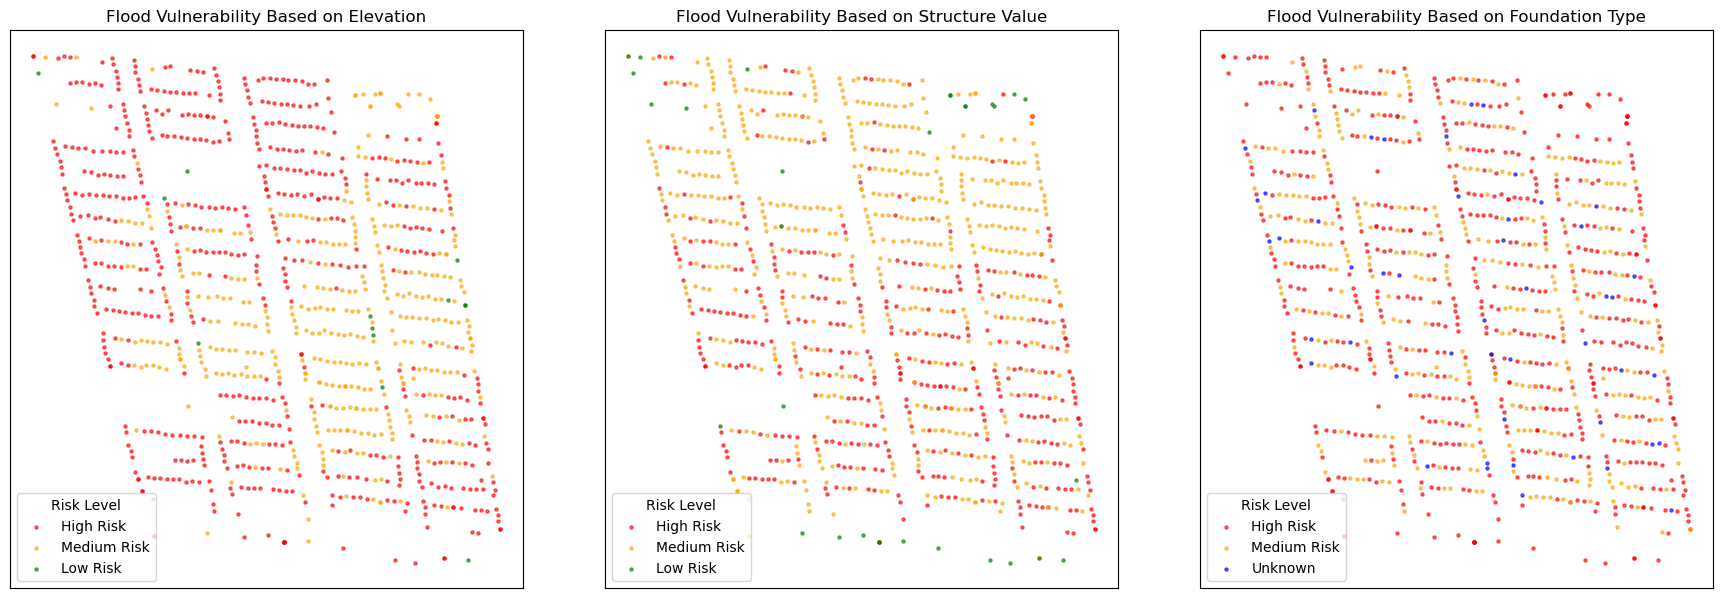

In [15]:
# Generate spatial maps for each vulnerability factor 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Elevation-based vulnerability map
for category, color in color_map.items():
  buildings[buildings["elevation_risk"] == category].plot(ax=axes[0], color=color, label=category, markersize=5, alpha=0.6)
axes[0].set_title("Flood Vulnerability Based on Elevation")
axes[0].legend(title="Risk Level")
axes[0].set_xticks([])
axes[0].set_yticks([])

# Structure value-based vulnerability map
for category, color in color_map.items():
  buildings[buildings["value_risk"] == category].plot(ax=axes[1], color=color, label=category, markersize=5, alpha=0.6)
axes[1].set_title("Flood Vulnerability Based on Structure Value")
axes[1].legend(title="Risk Level")
axes[1].set_xticks([])
axes[1].set_yticks([])

# Foundation type-based vulnerability map
for category, color in color_map.items():
  buildings[buildings["foundation_risk"] == category].plot(ax=axes[2], color=color, label=category, markersize=5, alpha=0.6)
axes[2].set_title("Flood Vulnerability Based on Foundation Type")
axes[2].legend(title="Risk Level")
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()
